In [1]:
!pip install pydicom
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 6.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:

import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import seaborn as sns

In [3]:
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm

In [4]:
PATH="../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection"
!ls ../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [5]:
train = pd.read_csv(join(PATH,'stage_2_train.csv'))
train.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [6]:
train['Sub_type'] = train['ID'].str.split("_", n = 2, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 2, expand = True)[1]
train.head()

,ID,Label,Sub_type,PatientID
0,ID_12cadc6af_epidural,0,epidural,12cadc6af
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af
4,ID_12cadc6af_subdural,0,subdural,12cadc6af


In [7]:
num_of_training_patients=len(os.listdir("/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train"))
num_of_testing_patients=len(os.listdir("/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test"))


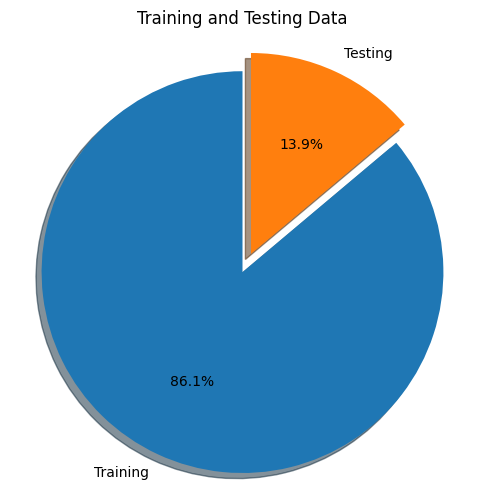

In [8]:
#ploting amount of training and testing data
labels = 'Training', 'Testing'
sizes = [num_of_training_patients, num_of_testing_patients]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Training and Testing Data')

plt.show()

Label
0    4260600
1     256242
Name: count, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

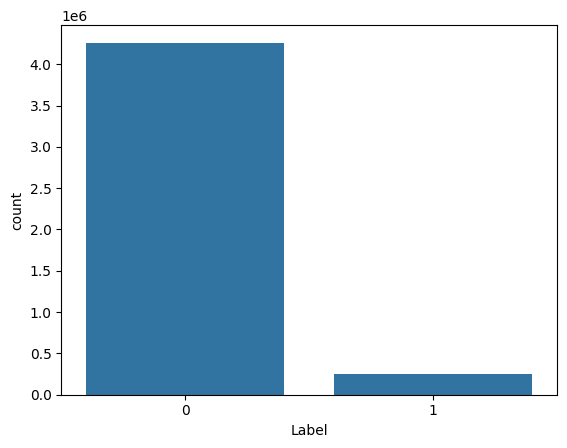

In [9]:
#Comparing 0 labels to 1 labels
print(train.Label.value_counts())
sns.countplot(x='Label', data=train)

In [10]:
#Number of each subtype labeled as 1
subtype_counts = train.groupby("Sub_type").Label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1]
subtype_counts


Sub_type
any                 107933
epidural              3145
intraparenchymal     36118
intraventricular     26205
subarachnoid         35675
subdural             47166
Name: 1, dtype: int64

Text(0.5, 1.0, 'Total Images by Subtype')

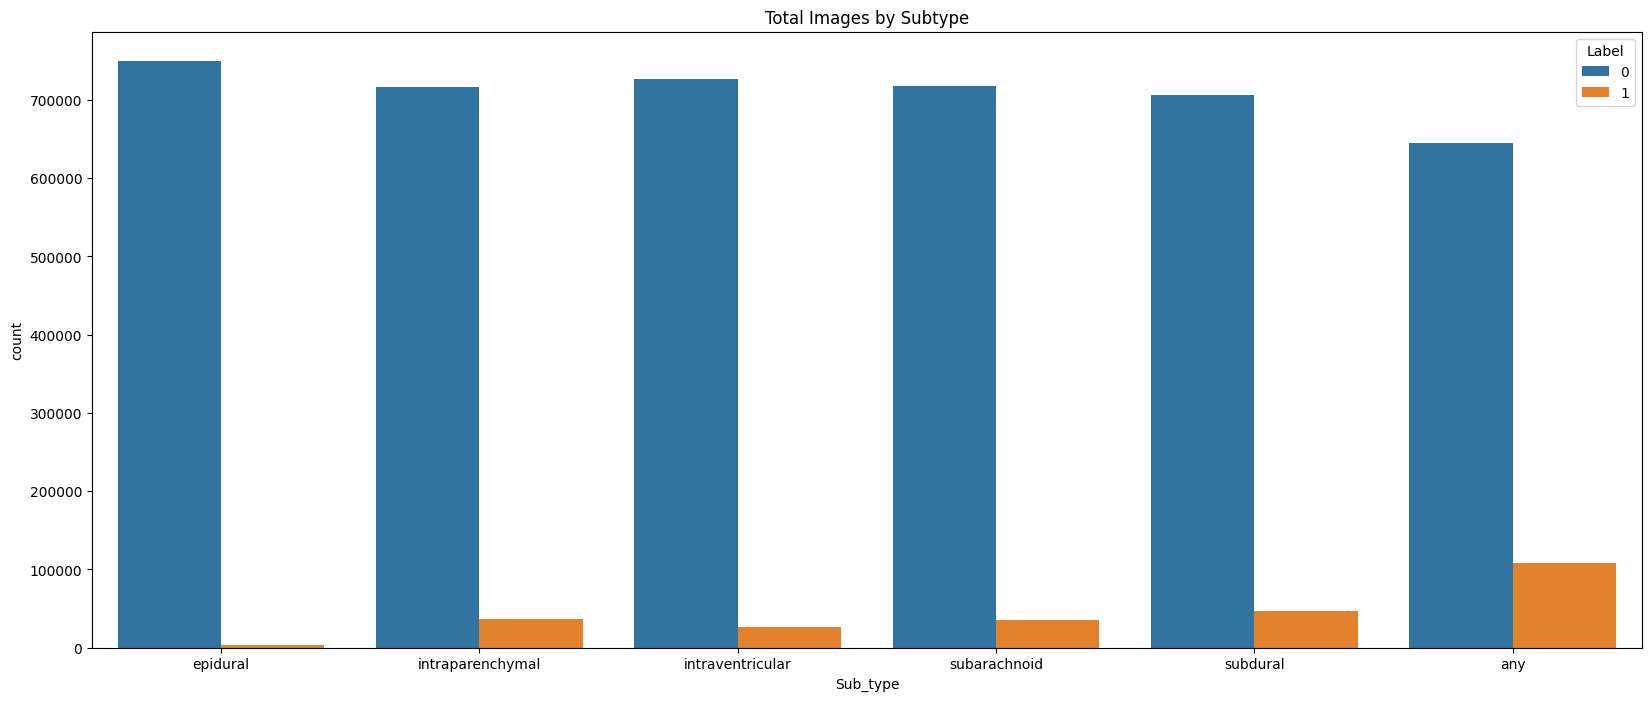

In [11]:
fig=plt.figure(figsize=(20, 8))

sns.countplot(x="Sub_type", hue="Label", data=train)

plt.title("Total Images by Subtype")

**Note:**
* The samples labeled with 0s are too much when compared to the samples labeled with 1s for each subtype.

/tmp/ipykernel_13/3879639564.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sizes = [subtype_counts[1],subtype_counts[2],subtype_counts[3],subtype_counts[4],subtype_counts[5]]


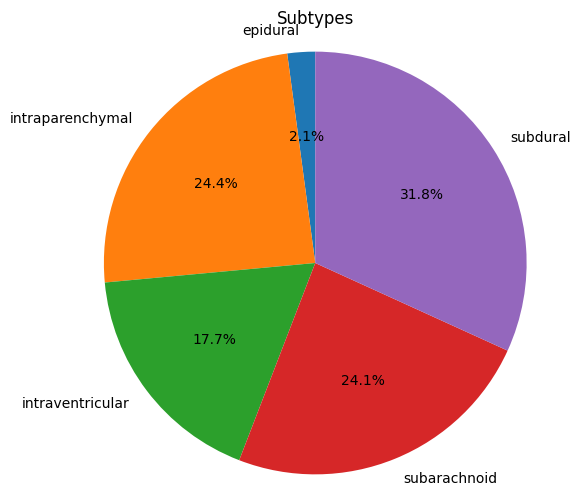

In [12]:
labels =  'epidural','intraparenchymal','intraventricular','subarachnoid','subdural'
sizes = [subtype_counts[1],subtype_counts[2],subtype_counts[3],subtype_counts[4],subtype_counts[5]]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
ax.set_title('Subtypes')

plt.show()

**Notes:**
*  We can see here that the data is not balanced, some subtypes have few examples, and that will make it hard to train the model to detectthose subtypes(epidural for example).
*  Data augmentation techniques will be required to perform the IH detection. Or random sampling can be used too, in such a way that the number of positive patients are equal to the number of negative patients. And as the data is so big I suggest to use subset of it, and the choosen subset have to balanced. 

In [13]:
traindf=train.copy()
traindf[['ID', 'Image', 'Diagnosis']] = traindf['ID'].str.split('_', expand=True)
traindf = traindf[['Image', 'Diagnosis', 'Label']]
traindf.drop_duplicates(inplace=True)
traindf = traindf.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
traindf['Image'] = 'ID_' + traindf['Image']
traindf.head(10)

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
5,ID_0000aee4b,0,0,0,0,0,0
6,ID_0000ca2f6,0,0,0,0,0,0
7,ID_0000f1657,0,0,0,0,0,0
8,ID_000178e76,0,0,0,0,0,0
9,ID_00019828f,0,0,0,0,0,0


In [14]:
#Cases with more than one IH subtype detected in the training dataset
x=[]
for n in range(6):
    many = traindf[traindf[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) == n].copy()
    x.append(len(many))
    print('Number of hemorrhages: {}, amount of such images: {}, fraction: {:.3f}%'.format(n, len(many), 100 * len(many) / len(traindf)))
    print(x[n])

Number of hemorrhages: 0, amount of such images: 644870, fraction: 85.663%
644870
Number of hemorrhages: 1, amount of such images: 75859, fraction: 10.077%
75859
Number of hemorrhages: 2, amount of such images: 24826, fraction: 3.298%
24826
Number of hemorrhages: 3, amount of such images: 6217, fraction: 0.826%
6217
Number of hemorrhages: 4, amount of such images: 1008, fraction: 0.134%
1008
Number of hemorrhages: 5, amount of such images: 23, fraction: 0.003%
23


Text(0.5, 0, 'class')

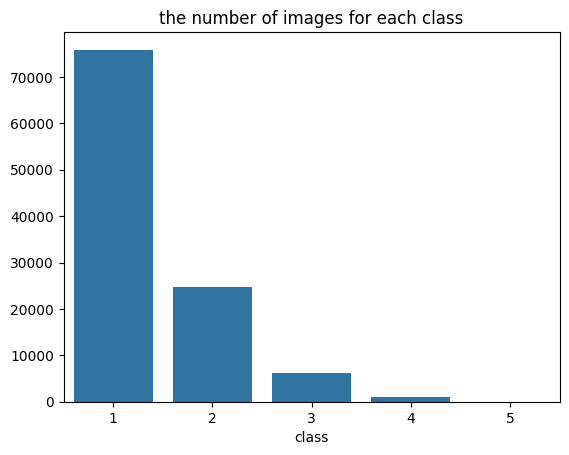

In [15]:
y=['0','1','2','3','4','5']
fig, ax = plt.subplots()
sns.barplot(x=list(y[1:]), y=list(x[1:]), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")

In [16]:
!pip install scikit-image

from skimage.io import imread_collection
import skimage.io
import skimage.color
import skimage.transform
from platform import python_version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 60.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 17.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


**Note:**
In most of the cases where IH is detected we have one subtype hemorhage detected. 

In [17]:
# extract filenames from the folder of images
filenames = []
for root, dirs, files in os.walk('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)
            
# should be the same as the images imported
len(filenames)

194082

In [18]:
col_dir = '../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/*.jpg'

# Create a collection with the available images
images = imread_collection(col_dir)

len(images)

194082

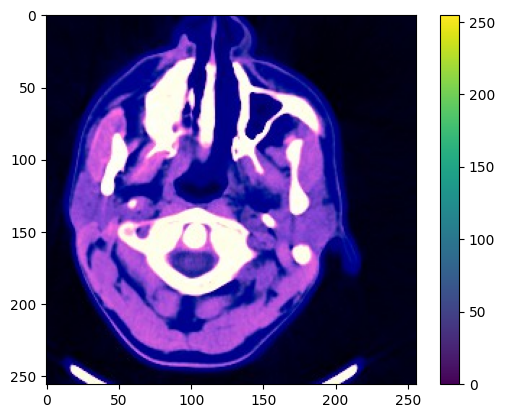

[[[ 0  0 26]
  [ 0  0 26]
  [ 0  0 26]
  ...
  [ 0  0 26]
  [ 0  0 26]
  [ 0  0 26]]

 [[ 0  0 26]
  [ 0  0 26]
  [ 0  0 26]
  ...
  [ 0  0 26]
  [ 0  0 26]
  [ 0  0 26]]

 [[ 0  0 24]
  [ 0  0 24]
  [ 0  0 26]
  ...
  [ 0  0 26]
  [ 0  0 26]
  [ 0  0 26]]

 ...

 [[ 0  0 28]
  [ 0  0 26]
  [ 0  1 22]
  ...
  [ 0  0 24]
  [ 0  0 24]
  [ 0  0 24]]

 [[ 2  0 24]
  [ 2  0 24]
  [ 0  0 24]
  ...
  [ 0  0 24]
  [ 0  0 24]
  [ 0  0 24]]

 [[ 2  0 22]
  [ 2  0 22]
  [ 0  0 24]
  ...
  [ 0  0 24]
  [ 0  0 24]
  [ 0  0 24]]]


In [19]:
# Plot the first image
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

print(images[0])

In [20]:
print(images[0].shape)
print(images[1].shape)
print(images[2].shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [21]:
# Select only the first 5000 images
images_trn = images[:2000]
print(len(images_trn))
images_val = images[20000:22000]
print(len(images_val))
images_tst = images[25000:30000]
print(len(images_tst))

2000
2000
5000


In [22]:
images_arr_trn = skimage.io.collection.concatenate_images(images_trn)
images_arr_val = skimage.io.collection.concatenate_images(images_val)
images_arr_tst = skimage.io.collection.concatenate_images(images_tst)

In [23]:
!pip install pyarrow
labels = pd.read_feather('../input/rsna-hemorrhage-jpg/meta/meta/labels.fth')

#manipulate the filenames list, stripping the .jpg at the end
idstosearch = [item.rstrip(".jpg") for item in filenames]

#now search the "ID" column for ids that correspond to our filenames
#made the reduced dataframe "labels2" for now
labels2 = labels[labels['ID'].isin(idstosearch)]
labels2.shape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 20.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


(194082, 7)

In [24]:
labels = labels2.iloc[:, 1]
print(labels)

2         0
4         0
11        0
12        1
19        0
         ..
674236    0
674250    0
674253    0
674254    0
674256    1
Name: any, Length: 194082, dtype: int64


In [25]:
labels_trn = labels[:2000]
print(len(labels_trn))
labels_val = labels[20000:22000]
print(len(labels_val))
labels_tst = labels[25000:30000]
print(len(labels_tst))

2000
2000
5000


In [26]:
print(type(labels_trn))
print(labels_trn.sum())

<class 'pandas.core.series.Series'>
1003


In [27]:
# Transform labels into array
labels_trn = pd.Series.to_numpy(labels_trn)
print(len(labels_trn))
labels_val = pd.Series.to_numpy(labels_val)
print(len(labels_val))
labels_tst = pd.Series.to_numpy(labels_tst)
print(len(labels_tst))

2000
2000
5000


In [28]:
from keras.applications import resnet50

model = resnet50.ResNet50(weights="imagenet")

2024-01-20 11:54:54.323408: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 11:54:54.323522: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 11:54:54.323597: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 11:54:54.323661: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 11:54:54.323773: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 11:54:54.323971: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 11:54:54.324056: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

102967424/102967424 [==============================] - 1s 0us/step


In [29]:
# Resize all images 

images_final = []

for i in range(len(images_arr_trn)):
  image_rescaled = skimage.transform.resize(images_arr_trn[i], (224, 224, 3))
  images_final.append(image_rescaled)

In [30]:
from skimage.transform import resize
# Resize validation images to (224, 224, 3)
images_val = [resize(image, (224, 224, 3)) for image in images_val]

# Resize test images to (224, 224, 3)
images_tst = [resize(image, (224, 224, 3)) for image in images_tst]

# Resize all images to 224x224
images_final_resized = [resize(image, (224, 224, 3)) for image in images_final]

*Model*

In [31]:
!pip install scikit-optimize

import keras
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from skimage.transform import resize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
#from keras.wrappers.scikit_learn import KerasClassifier
from skopt import BayesSearchCV
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import resnet50
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [32]:
from keras.utils import to_categorical

num_classes=6

# Assuming labels are integers (0, 1, 2, ..., num_classes-1)
labels_trn_one_hot = to_categorical(labels_trn, num_classes)
labels_val_one_hot = to_categorical(labels_val, num_classes)

My model

In [33]:
"""import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense

def small_module1(input_image):
    # Convolutional layers with reduced complexity
    conv_a = Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(input_image)
    conv_b = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(input_image)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b])

    # Convolution after merge
    module1out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module1out

def small_module2(module1out):
    # Convolutional layers with reduced complexity
    conv_a = Conv2D(filters=64, kernel_size=5, activation='relu', padding='same')(module1out)
    conv_b = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(module1out)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b])

    # Convolution after merge
    module2out = Conv2D(filters=64, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module2out

def small_classification_block(module1out, module2out):
    # Multiply MSFE1 with attention_output
    attended_features = tf.multiply(module1out, module2out)

    # Global Average Pooling
    global_avg_pool = GlobalAveragePooling2D()(attended_features)

    # Fully Connected and Sigmoid for classification
    output_layer = Dense(units=3, activation='softmax')(global_avg_pool)

    return output_layer

# Input layer
height, width, channels = 224, 224, 3
input_image = Input(shape=(height, width, channels))

# Small MSFE
small_module1_out = small_module1(input_image)

# Small Attention Block
small_module2_out = small_module2(small_module1_out)

# Small Classification Block
small_output_layer = small_classification_block(small_module1_out, small_module2_out)

# Create the small model
small_model = tf.keras.Model(inputs=input_image, outputs=small_output_layer)

# Compile the small model
small_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the small model architecture
small_model.summary()
"""

'import tensorflow as tf\nfrom tensorflow.keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense\n\ndef small_module1(input_image):\n    # Convolutional layers with reduced complexity\n    conv_a = Conv2D(filters=32, kernel_size=5, activation=\'relu\', padding=\'same\')(input_image)\n    conv_b = Conv2D(filters=64, kernel_size=3, activation=\'relu\', padding=\'same\')(input_image)\n\n    # Merge the convolutional layers\n    merged = concatenate([conv_a, conv_b])\n\n    # Convolution after merge\n    module1out = Conv2D(filters=1, kernel_size=1, activation=\'sigmoid\', padding="same")(merged)\n\n    return module1out\n\ndef small_module2(module1out):\n    # Convolutional layers with reduced complexity\n    conv_a = Conv2D(filters=64, kernel_size=5, activation=\'relu\', padding=\'same\')(module1out)\n    conv_b = Conv2D(filters=128, kernel_size=3, activation=\'relu\', padding=\'same\')(module1out)\n\n    # Merge the convolutional layers\n    merged = concatenate([

In [34]:
"""import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, concatenate, Reshape, Softmax, Multiply, GlobalAveragePooling2D, Dense

def module1(input_image):
    # Convolutional layers
    conv_a = Conv2D(filters=64, kernel_size=8, activation='relu', padding='same')(input_image)
    conv_b = Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(input_image)
    conv_c = Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')(input_image)
    conv_d = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(input_image)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module1out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module1out


def module2(module1out):
    # Convolutional layers
    conv_a = Conv2D(filters=128, kernel_size=8, activation='relu', padding='same')(module1out)
    conv_b = Conv2D(filters=256, kernel_size=4, activation='relu', padding='same')(module1out)
    conv_c = Conv2D(filters=512, kernel_size=2, activation='relu', padding='same')(module1out)
    conv_d = Conv2D(filters=1024, kernel_size=1, activation='relu', padding='same')(module1out)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module2out = Conv2D(filters=128, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module2out



def classification_block(module1out, module2out):
    # Multiply MSFE1 with attention_output
    attended_features = Multiply()([module1out, module2out])

    # Convolution after attention
    conv_attention = Conv2D(filters=128, kernel_size=3, activation='relu')(attended_features)

    # Global Average Pooling
    global_avg_pool = GlobalAveragePooling2D()(conv_attention)

    # Fully Connected and Sigmoid for classification
    output_layer = Dense(units=6, activation='sigmoid')(global_avg_pool)

    return output_layer

# Input layer

height, width, channels = 224, 224, 3

input_image = Input(shape=(height, width, channels))

# MSFE
module1out = module1(input_image)

# Attention Block
module2out = module2(module1out)

# Classification Block
output_layer = classification_block(module1out, module2out)

# Create the model
model = tf.keras.Model(inputs=input_image, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()
"""

'import tensorflow as tf\nfrom tensorflow.keras.layers import Input, Conv2D, concatenate, Reshape, Softmax, Multiply, GlobalAveragePooling2D, Dense\n\ndef module1(input_image):\n    # Convolutional layers\n    conv_a = Conv2D(filters=64, kernel_size=8, activation=\'relu\', padding=\'same\')(input_image)\n    conv_b = Conv2D(filters=128, kernel_size=4, activation=\'relu\', padding=\'same\')(input_image)\n    conv_c = Conv2D(filters=256, kernel_size=2, activation=\'relu\', padding=\'same\')(input_image)\n    conv_d = Conv2D(filters=512, kernel_size=1, activation=\'relu\', padding=\'same\')(input_image)\n\n    # Merge the convolutional layers\n    merged = concatenate([conv_a, conv_b, conv_c, conv_d])\n\n    # Convolution after merge\n    module1out = Conv2D(filters=1, kernel_size=1, activation=\'sigmoid\', padding="same")(merged)\n\n    return module1out\n\n\ndef module2(module1out):\n    # Convolutional layers\n    conv_a = Conv2D(filters=128, kernel_size=8, activation=\'relu\', padding

In [35]:
  import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, concatenate, Reshape, Softmax, Multiply, GlobalAveragePooling2D, Dense

def module1(input_image):
    # Convolutional layers
    conv_a = Conv2D(filters=64, kernel_size=8, activation='relu', padding='same')(input_image)
    conv_b = Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(input_image)
    conv_c = Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')(input_image)
    conv_d = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(input_image)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module1out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module1out


def module2(input_image, module1out):

    # Merge input with module1 output
    mergedmodule2 = concatenate([input_image, module1out])


    # Convolutional layers
    conv_a = Conv2D(filters=64, kernel_size=8, activation='relu', padding='same')(mergedmodule2)
    conv_b = Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(mergedmodule2)
    conv_c = Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')(mergedmodule2)
    conv_d = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(mergedmodule2)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module2out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module2out

def module3(input_image, module2out):

    # Merge input with module1 output
    mergedmodule3 = concatenate([input_image, module2out])


    # Convolutional layers
    conv_a = Conv2D(filters=64, kernel_size=8, activation='relu', padding='same')(mergedmodule3)
    conv_b = Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(mergedmodule3)
    conv_c = Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')(mergedmodule3)
    conv_d = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(mergedmodule3)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module3out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module3out

def module4(input_image, module3out):

    # Merge input with module1 output
    mergedmodule3 = concatenate([input_image, module3out])


    # Convolutional layers
    conv_a = Conv2D(filters=64, kernel_size=8, activation='relu', padding='same')(mergedmodule3)
    conv_b = Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(mergedmodule3)
    conv_c = Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')(mergedmodule3)
    conv_d = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(mergedmodule3)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module4out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module4out


def module5(input_image, module1out,module2out,module3out):

    # Merge input with module1 output
    mergedmodule5 = concatenate([input_image, module1out,module2out,module3out])


    # Convolutional layers
    conv_a = Conv2D(filters=64, kernel_size=8, activation='relu', padding='same')(mergedmodule5)
    conv_b = Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(mergedmodule5)
    conv_c = Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')(mergedmodule5)
    conv_d = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(mergedmodule5)

    # Merge the convolutional layers
    merged = concatenate([conv_a, conv_b, conv_c, conv_d])

    # Convolution after merge
    module5out = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding="same")(merged)

    return module5out




def module6(module5out):
    # Multiply MSFE1 with attention_output
    #attended_features = Multiply()([module1out, module2out])

    # Convolution after attention
    conv_module6 = Conv2D(filters=128, kernel_size=3, activation='relu')(module5out)

    # Global Average Pooling
    global_avg_pool = GlobalAveragePooling2D()(conv_module6)

    # Fully Connected and Sigmoid for classification
    output_layer = Dense(6, activation='softmax')(global_avg_pool)

    return output_layer





# Input layer

height, width, channels = 224, 224, 3

input_image = Input(shape=(height, width, channels))




# module1
module1out = module1(input_image)

# module2
module2out = module2(input_image, module1out)

# module3
module3out = module3(input_image, module2out)

# module4
module4out = module4(input_image, module3out)

# module5
module5out = module5(input_image, module1out,module2out,module3out)

# module6
output_layer = module6(module5out)

# Create the model
model = tf.keras.Model(inputs=input_image, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         12352     ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 128)        6272      ['input_2[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 224, 224, 256)        3328      ['input_2[0][0]']             
                                                                                              

Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Define initial variables and callbacks
best_val_accuracy = 0.0
checkpoint_path = 'best_model_weights.h5'

# Containers to store metrics
history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}


# Define a callback to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


# Give the Epoch number
epochs=10


# Train the model
for epoch in range(epochs):
    # Fit the model and collect history
    hist = model.fit(
        np.array(images_final),  # Input images
        labels_trn_one_hot,  # Target labels
        epochs=1,
        batch_size=64,
        validation_data=(np.array(images_val), labels_val_one_hot),
        callbacks=[checkpoint]
    )  
    
  # Append the training history for this epoch to the overall history
    history['accuracy'].extend(hist.history['accuracy'])
    history['val_accuracy'].extend(hist.history['val_accuracy'])
    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])

    # Evaluate on validation data after each epoch
    y_val_pred = model.predict(np.array(images_val))
    # Convert predictions to class indices
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    # Assuming labels_val is one-hot encoded
    labels_val_classes = np.argmax(labels_val_one_hot, axis=1)

    val_accuracy = accuracy_score(labels_val_classes, y_val_pred_classes)
    val_precision = precision_score(labels_val_classes, y_val_pred_classes, average='weighted')
    val_recall = recall_score(labels_val_classes, y_val_pred_classes, average='weighted')
    val_f1 = f1_score(labels_val_classes, y_val_pred_classes, average='weighted')

    # Check if validation accuracy has improved
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_weights_filename = f"model_weights_epoch_own_{epoch + 1}.h5"#model weights name change it according to the name of the model used
        print(f"Epoch {epoch + 1} - Validation Accuracy Improved: {best_val_accuracy:.4f}. Saving model weights as {model_weights_filename}.")
        model.save_weights(model_weights_filename)  # Save the model weights

    
    print(f"Epoch {epoch + 1} - Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")





23/32 [====================>.........] - ETA: 8:02 - loss: 1.5415 - accuracy: 0.4518

In [ ]:


# Plotting accuracy and loss for each epoch
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Test

In [ ]:

# Evaluate the model on test data after training
y_test_pred = model.predict(np.array(images_tst))

# Convert predictions to class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Assuming labels_tst is one-hot encoded
labels_tst_classes = np.argmax(to_categorical(labels_tst, num_classes), axis=1)



# Use multi-class metrics
test_accuracy = accuracy_score(labels_tst_classes, y_test_pred_classes)
test_precision = precision_score(labels_tst_classes, y_test_pred_classes, average='weighted')
test_recall = recall_score(labels_tst_classes, y_test_pred_classes, average='weighted')
test_f1 = f1_score(labels_tst_classes, y_test_pred_classes, average='weighted')


print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")



In [ ]:
from keras.models import load_model

# Load the saved weights into your model
model.load_weights('/kaggle/working/best_model_weights.h5')  

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming labels_tst is one-hot encoded
labels_tst_classes = np.argmax(to_categorical(labels_tst, num_classes), axis=1)

# Convert predictions to class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Compute precision, recall, and f1 score for each class
class_precisions = [precision_score(labels_tst_classes == i, y_test_pred_classes == i, average='weighted') for i in range(num_classes)]
class_recalls = [recall_score(labels_tst_classes == i, y_test_pred_classes == i, average='weighted') for i in range(num_classes)]
class_f1_scores = [f1_score(labels_tst_classes == i, y_test_pred_classes == i, average='weighted') for i in range(num_classes)]

# Display the metrics for each class
for i, (precision, recall, f1) in enumerate(zip(class_precisions, class_recalls, class_f1_scores)):
    print(f"Class {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}")


In [ ]:
# Assuming you have test images in the 'test_images' variable
# Replace this with your actual test data
test_predictions = model.predict(np.array(images_tst))

# Display the predictions or use them as needed
print(test_predictions)

In [ ]:
images_val = []

for i in range(len(images_arr_val)):
  image_rescaled = skimage.transform.resize(images_arr_val[i], (224, 224, 3))
  images_val.append(image_rescaled)

In [ ]:
images_val = skimage.io.collection.concatenate_images(images_val)

In [ ]:
# Validate model
test_loss, test_acc = model.evaluate(images_val, labels_val_one_hot, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming labels_tst is one-hot encoded
labels_tst_classes = np.argmax(to_categorical(labels_tst, num_classes), axis=1)

# Convert predictions to class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Compute precision, recall, and f1 score for each class
class_precisions = [precision_score(labels_tst_classes == i, y_test_pred_classes == i, average='weighted') for i in range(num_classes)]
class_recalls = [recall_score(labels_tst_classes == i, y_test_pred_classes == i, average='weighted') for i in range(num_classes)]
class_f1_scores = [f1_score(labels_tst_classes == i, y_test_pred_classes == i, average='weighted') for i in range(num_classes)]

# Display the metrics for each class
for i, (precision, recall, f1) in enumerate(zip(class_precisions, class_recalls, class_f1_scores)):
    print(f"Class {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Assuming labels_tst is one-hot encoded
unique_classes = np.unique(to_categorical(labels_tst, num_classes).argmax(axis=1))
num_classes = len(unique_classes)


# Convert predictions to class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Compute precision, recall, and f1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(labels_tst_classes, y_test_pred_classes, average=None)

# Display the metrics for each class
for i, (prec, rec, f1_score) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}, F1 Score = {f1_score:.4f}")

# Plotting precision, recall, and f1 score for each class
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Precision
axes[0].bar(unique_classes, precision, color='blue', alpha=0.7)
axes[0].set_xticks(unique_classes)
axes[0].set_title('Precision for Each Class')

# Recall
axes[1].bar(unique_classes, recall, color='green', alpha=0.7)
axes[1].set_xticks(unique_classes)
axes[1].set_title('Recall for Each Class')

# F1 Score
axes[2].bar(unique_classes, f1, color='orange', alpha=0.7)
axes[2].set_xticks(unique_classes)
axes[2].set_title('F1 Score for Each Class')

plt.tight_layout()
plt.show()



In [ ]:
# Assuming labels_tst is one-hot encoded
unique_classes = np.unique(to_categorical(labels_tst, num_classes).argmax(axis=1))
num_classes = len(unique_classes)

# Convert predictions to class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Compute precision, recall, and f1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(labels_tst_classes, y_test_pred_classes, labels=unique_classes)

# Display the metrics for each class
for i, (prec, rec, f1_score) in enumerate(zip(precision, recall, f1)):
    print(f"Class {unique_classes[i]}: Precision = {prec:.4f}, Recall = {rec:.4f}, F1 Score = {f1_score:.4f}")

# Plotting precision, recall, and f1 score for each class
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Precision
axes[0].bar(unique_classes, precision, color='blue', alpha=0.7)
axes[0].set_xticks(unique_classes)
axes[0].set_title('Precision for Each Class')

# Recall
axes[1].bar(unique_classes, recall, color='green', alpha=0.7)
axes[1].set_xticks(unique_classes)
axes[1].set_title('Recall for Each Class')

# F1 Score
axes[2].bar(unique_classes, f1, color='orange', alpha=0.7)
axes[2].set_xticks(unique_classes)
axes[2].set_title('F1 Score for Each Class')

plt.tight_layout()
plt.show()
